# Fantasy Premier League Analysis and Player-Transfer Prediction

This notebook will analyse trends and strategies in FPL. FPL can be looked upon as a econometric problem. The players are like commodeties to be bought and sold, but with a slight difference that the dependent variable isn't player price, but rather the total points, which in econometric terms can be looked upon as their revenue/profits.\
I.E. the econometric problem statement would then be to find the stock which we can predict the highest future profits with a limited budget. **Or in terms of FPL again, to find the player with the highest expected total points with a limited budget.**

In [1]:
# !pip install xgboost==1.1.1
# !pip install statsmodels==0.13.0

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools, pytz, statsmodels, scipy, patsy, copy, warnings
from sklearn.metrics import mean_squared_error
from collections import deque
from sklearn.preprocessing import StandardScaler

# ARIMA library
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from statsmodels.tsa.stattools import adfuller

# SVM library
from sklearn.svm import SVR

#XGBoost library
import xgboost as xgb

# Recurrent Neural Network library
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.layers import Dropout, Layer

Statsmodels needs to be in version 0.13.0. If it has an older version, run the pip install version above

In [3]:
print('XGBoost', xgb.__version__)
print('Statsmodels', statsmodels.__version__)
print('Tensorflow', tf.__version__)

XGBoost 1.1.1
Statsmodels 0.13.0
Tensorflow 2.8.0


## Data Gathering and Pre-Processing

Detailed description below. This will mostly take use of the Pandas library, as it is a very powerful and flexible tool for manipulating and analysing data

In [4]:
# Importing the player data for the seasons from 2020 to 2022
df = pd.DataFrame()
seasons = ['2021-22', '2020-21']
for s in seasons:
    for i in range(1, 39):
        temp = pd.read_csv("https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/master/data/" + s + "/gws/gw" + str(i) + ".csv")
        temp['season'] = [s for _ in range(len(temp))]
        df = pd.concat([df, temp])
        # print(f" season: {s}, gw: {i} complete")

# This data is being imported different from season 20-21 and 21-22 because the URL is different from above
s19_20 = pd.read_csv("https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/master/data/2019-20/gws/merged_gw.csv")
s19_20['season'] = ['2019-20' for _ in range(len(s19_20))]
df = pd.concat([df, s19_20])

# Dropping initial irrelevant features and converging object relevant features from objects to numeric values
df.reset_index(inplace=True)
# print(df.columns)
df.drop(['index', 'xP', 'transfers_balance', 'transfers_in', 'transfers_out', 'GW'], axis=1, inplace=True)
df = df.astype({'assists' : 'int64',
                'bonus' : 'int64',
                'bps' : 'float64',
                'clean_sheets' : 'int64',
                'goals_conceded' : 'int64',
                'goals_scored' : 'int64',
                'minutes' : 'int64',
                'opponent_team' : 'int64', 
                'own_goals' : 'int64', 
                'penalties_missed' : 'int64', 
                'penalties_saved' : 'int64',
                'red_cards' : 'int64', 
                'round' : 'int64', 
                'saves' : 'int64', 
                'selected' : 'int64', 
                'threat' : 'float64', 
                'total_points' : 'int64',
                'value' : 'int64', 
                'was_home' : 'int64', 
                'yellow_cards' : 'int64'}, errors='ignore')

print(df.shape)
df.head()

(72372, 32)


,name,position,team,assists,bonus,bps,clean_sheets,creativity,element,fixture,...,saves,selected,team_a_score,team_h_score,threat,total_points,value,was_home,yellow_cards,season
0,Eric Bailly,DEF,Man Utd,0,0,0.0,0,0.0,286,6,...,0,9363,1.0,5.0,0.0,0,50,1,0,2021-22
1,Keinan Davis,FWD,Aston Villa,0,0,0.0,0,0.0,49,8,...,0,169789,2.0,3.0,0.0,0,45,0,0,2021-22
2,Ayotomiwa Dele-Bashiru,MID,Watford,0,0,0.0,0,0.0,394,8,...,0,4092,2.0,3.0,0.0,0,45,1,0,2021-22
3,James Ward-Prowse,MID,Southampton,0,0,20.0,0,30.5,341,4,...,0,299682,1.0,3.0,0.0,2,65,0,0,2021-22
4,Bruno Miguel Borges Fernandes,MID,Man Utd,0,3,61.0,0,35.9,277,6,...,0,3381004,1.0,5.0,59.0,20,120,1,0,2021-22


In [5]:
round(df.describe(), 2)

,assists,bonus,bps,clean_sheets,creativity,element,fixture,goals_conceded,goals_scored,ict_index,...,round,saves,selected,team_a_score,team_h_score,threat,total_points,value,was_home,yellow_cards
count,72372.00,72372.00,72372.00,72372.0,72372.00,72372.00,72372.00,72372.00,72372.00,72372.00,...,72372.00,72372.00,72372.00,72313.00,72313.00,72372.00,72372.00,72372.00,72372.0,72372.00
mean,0.04,0.10,5.69,0.1,4.45,320.57,198.86,0.48,0.04,1.63,...,21.39,0.09,187937.25,1.28,1.46,5.13,1.30,51.31,0.5,0.05
std,0.21,0.48,9.52,0.3,10.36,188.08,109.02,0.95,0.22,2.98,...,12.11,0.62,463713.64,1.24,1.30,13.32,2.47,12.25,0.5,0.22
min,0.00,0.00,-16.00,0.0,0.00,1.00,1.00,0.00,0.00,0.00,...,1.00,0.00,0.00,0.00,0.00,0.00,-7.00,37.00,0.0,0.00
25%,0.00,0.00,0.00,0.0,0.00,159.00,106.00,0.00,0.00,0.00,...,11.00,0.00,5738.00,0.00,0.00,0.00,0.00,44.00,0.0,0.00
50%,0.00,0.00,0.00,0.0,0.00,318.00,203.00,0.00,0.00,0.00,...,22.00,0.00,25493.00,1.00,1.00,0.00,0.00,48.00,0.0,0.00
75%,0.00,0.00,10.00,0.0,2.00,477.00,294.00,1.00,0.00,2.30,...,31.00,0.00,134878.75,2.00,2.00,2.00,2.00,55.00,1.0,0.00
max,4.00,3.00,128.00,1.0,136.20,737.00,380.00,9.00,4.00,35.80,...,47.00,12.00,6483921.00,9.00,9.00,181.00,26.00,133.00,1.0,1.00


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72372 entries, 0 to 72371
Data columns (total 32 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              72372 non-null  object 
 1   position          49812 non-null  object 
 2   team              49812 non-null  object 
 3   assists           72372 non-null  int64  
 4   bonus             72372 non-null  int64  
 5   bps               72372 non-null  float64
 6   clean_sheets      72372 non-null  int64  
 7   creativity        72372 non-null  float64
 8   element           72372 non-null  int64  
 9   fixture           72372 non-null  int64  
 10  goals_conceded    72372 non-null  int64  
 11  goals_scored      72372 non-null  int64  
 12  ict_index         72372 non-null  float64
 13  influence         72372 non-null  float64
 14  kickoff_time      72372 non-null  object 
 15  minutes           72372 non-null  int64  
 16  opponent_team     72372 non-null  int64 

When looking at the dataset we see that each team is represented as numbers, to fix this we can create two dictionaries; one where the team is the key and the index-number is the value and the other one where it's the opposite. Seeing as the index will change from season to season depending on which team gets relegated and promoted, it will have to be a nested dictionary for each season. 

It should look like this:\
{'2021-22' : {'Arsenal' : 1, 'Aston Villa' : 2,...}}

In [7]:
seasons = ['2021-22', '2020-21', '2019-20']

# Creating dicts of team names and index values
team_ix_list = pd.read_csv("https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/master/data/master_team_list.csv")
team2ix = {s : {team_ix_list[team_ix_list['season'] == s]['team_name'].iloc[i] : team_ix_list[team_ix_list['season'] == s]['team'].iloc[i]  for i in range(20)} for s in seasons}
ix2team = {s : {team_ix_list[team_ix_list['season'] == s]['team'].iloc[i] : team_ix_list[team_ix_list['season'] == s]['team_name'].iloc[i]  for i in range(20)} for s in seasons}
print(team2ix)
print(ix2team)

{'2021-22': {'Arsenal': 1, 'Aston Villa': 2, 'Brentford': 3, 'Brighton': 4, 'Burnley': 5, 'Chelsea': 6, 'Crystal Palace': 7, 'Everton': 8, 'Leicester': 9, 'Leeds': 10, 'Liverpool': 11, 'Man City': 12, 'Man Utd': 13, 'Newcastle': 14, 'Norwich': 15, 'Southampton': 16, 'Spurs': 17, 'Watford': 18, 'West Ham': 19, 'Wolves': 20}, '2020-21': {'Arsenal': 1, 'Aston Villa': 2, 'Brighton': 3, 'Burnley': 4, 'Chelsea': 5, 'Crystal Palace': 6, 'Everton': 7, 'Fulham': 8, 'Leicester': 9, 'Leeds': 10, 'Liverpool': 11, 'Man City': 12, 'Man Utd': 13, 'Newcastle': 14, 'Sheffield Utd': 15, 'Southampton': 16, 'Spurs': 17, 'West Brom': 18, 'West Ham': 19, 'Wolves': 20}, '2019-20': {'Arsenal': 1, 'Aston Villa': 2, 'Bournemouth': 3, 'Brighton': 4, 'Burnley': 5, 'Chelsea': 6, 'Crystal Palace': 7, 'Everton': 8, 'Leicester': 9, 'Liverpool': 10, 'Man City': 11, 'Man Utd': 12, 'Newcastle': 13, 'Norwich': 14, 'Sheffield Utd': 15, 'Southampton': 16, 'Spurs': 17, 'Watford': 18, 'West Ham': 19, 'Wolves': 20}}
{'2021-22

### Filling the NaNs

Since all players from the 2019-20 season has missing positions and teams, we can fill their NaNs with the first value of each individual player in the following season. It won't be 100 % accurate seeing as some players changed their positions and teams, but this shouldn't affect the data information in a too negative way. 

First the names needs to be in the same format as the rest:

In [8]:
# Reformating the player names of the 2019-20 season
for name in df[df['season'] == '2019-20']['name']:
    temp = name.replace("_", " ")
    temp = temp[:[i-1 for i, j in enumerate(temp) if j.isnumeric()][0]] # Removing all characters after the actual name
    df['name'].replace(name, temp, inplace=True)    

df.head()

,name,position,team,assists,bonus,bps,clean_sheets,creativity,element,fixture,...,saves,selected,team_a_score,team_h_score,threat,total_points,value,was_home,yellow_cards,season
0,Eric Bailly,DEF,Man Utd,0,0,0.0,0,0.0,286,6,...,0,9363,1.0,5.0,0.0,0,50,1,0,2021-22
1,Keinan Davis,FWD,Aston Villa,0,0,0.0,0,0.0,49,8,...,0,169789,2.0,3.0,0.0,0,45,0,0,2021-22
2,Ayotomiwa Dele-Bashiru,MID,Watford,0,0,0.0,0,0.0,394,8,...,0,4092,2.0,3.0,0.0,0,45,1,0,2021-22
3,James Ward-Prowse,MID,Southampton,0,0,20.0,0,30.5,341,4,...,0,299682,1.0,3.0,0.0,2,65,0,0,2021-22
4,Bruno Miguel Borges Fernandes,MID,Man Utd,0,3,61.0,0,35.9,277,6,...,0,3381004,1.0,5.0,59.0,20,120,1,0,2021-22


Players wo didn't play in the coming seasons and thus can't fill their NaNs will be irrelevant for the analysis anyways, so they can be safely removed.

In [9]:
# Filling NaN values with the first values of 2020-21 season
for n in pd.unique(df[df['season'] == '2019-20']['name']):
    df[df['name'] == n] = df[df['name'] == n].fillna(method='ffill')
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True) # Need to reset the index after dropping missing data.

# Displaying the number of remanining missing values in the df
df.isnull().sum().sum()

0

Opponent teams are represented as index numbers. To visualize it better, we can change it back to their alphabetic names.

In [10]:
# Replacing the index values of the opponent team with their actual names
for s, adict in ix2team.items():
    df[df['season'] == s] = df[df['season'] == s].replace({'opponent_team': adict})
    
df[['team', 'opponent_team']].head()

,team,opponent_team
0,Man Utd,Leeds
1,Aston Villa,Watford
2,Watford,Aston Villa
3,Southampton,Everton
4,Man Utd,Leeds


In [11]:
# Displaying the initial number of players and teams
print(f"Number of players: {len(pd.unique(df['name']))}")
print(f"Number of teams: {len(pd.unique(df['team']))}")

Number of players: 989
Number of teams: 23


As we want to predict future performances of players we can remove players who left the Premier League before the latest 2021-22 season.

In [12]:
# Dropping players that isn't anymore in the PL
count = 0
for player in pd.unique(df[df['season'] == '2021-22']['name']):
    if player not in pd.unique(df[df['season'] != '2021-22']['name']):
        df.drop(index = df[df['name'] == player].index, axis=0, inplace=True)
        count += 1
    else:
        pass

# Displaying the number of players dropped
print(f"{count} players dropped.")

# Reseting the index after dropping players
df.reset_index(inplace=True, drop=True)

229 players dropped.


Thanks to COVID-19, many of the games in the 2019-20, after game week 28 were post-poned to be played in June instead. In the 2020-21 and 2021-22 seasons, some games were delayed due to COVID outbreaks in the teams, and this could affect the number of games a player played in the seasons. Donny van de Beek is an example of this, playing for Man United in 2021 and going out on loan to Everton in January 2022. Because Everton had games delayed due to COVID, van de Beek were involved in 40 games in the 2021-22 season, which is 2 games more than normal.

Because season is not an important factor, adding making a smooth time-series from 1 to the number of games involvements can be made. For most players, they will have 114 games played, but for a few players, they could have slightly more or less.

In [13]:
# Reshaping gameweek number to a continuous time step
for player in pd.unique(df["name"]):
    #print(player)
    idx = df[df['name'] == player].index
    l = len(idx)
    df.iloc[idx, 9] = np.linspace(1, l, l)
    #print(new_df.iloc[idx, 9])

In [14]:
#for s in seasons:
#    for player in pd.unique(df[df['season'] == s]['name']):
#        l = len(df[(df['name'] == player) & (df['season'] == s)]['fixture'])
#        ixs = df[(df['name'] == player) & (df['season'] == s)]['fixture'].index
#        df.iloc[ixs, 9] = np.linspace(1, l, l).astype('int32')

# df[(df['name'] == 'Anwar El Ghazi') & (df['season'] == '2021-22')][['name', 'team', 'opponent_team', 'fixture']].head()

### Fixture Difficulty Rating

FDR is described as a complex algorithm made by Opta to help fpl managers with their desicion-making of player purchases by informing them of the difficulty of their future opponents.

In the Fixtures.csv-file we find the relevant dataset for the FDR. First we will download the csv-files for the relevant seasons:

In [15]:
seasons = ['2021-22', '2020-21', '2019-20']

# Creating a fixtures-dataframe for merging FDRs 
fix = pd.DataFrame()
for s in seasons:
    temp = pd.read_csv('https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/master/data/'+ s +'/fixtures.csv')
    temp['season'] = [s for _ in range(len(temp))]
    fix = pd.concat([fix, temp])
fix.drop(['id', 'minutes' ,'code', 'event', 'finished', 'finished_provisional', 'provisional_start_time', 'started', 'stats', 'kickoff_time'], axis=1, inplace=True)

# Replacing index numbers with team names
for s, adict in ix2team.items():
    fix[fix['season'] == s] = fix[fix['season'] == s].replace({'team_a': adict, 'team_h':adict})

# print(fix.shape)
fix = fix.astype({'team_a_score' : 'int64',
                  'team_h_score' : 'int64',
                  'team_h_difficulty' : 'int64',
                  'team_a_difficulty' : 'int64',
                  'pulse_id' : 'float64'}, errors='ignore')
fix.head()

,team_a,team_a_score,team_h,team_h_score,team_h_difficulty,team_a_difficulty,pulse_id,season
0,Arsenal,0,Brentford,2,4,2,66342.0,2021-22
1,Leeds,1,Man Utd,5,2,4,66347.0,2021-22
2,Brighton,2,Burnley,1,2,2,66343.0,2021-22
3,Crystal Palace,0,Chelsea,3,2,4,66344.0,2021-22
4,Southampton,1,Everton,3,2,2,66345.0,2021-22


A current challenge with the Vaastav player dataset is that it records the score of each game as "Home team score" and "Away team score", which can be difficult to interpret seeing as the player can be both home and away (though, not at the same time). It would be easier to change this scoring system into "team_score" and "opponent_score" so that we have one feature for which the team of the player has recorded their scores, and one feature for which the opponents score is recorded, and to track whether it was a home-game or not, we can use the pre-existing "was_home" feature.

In [16]:
# Replacing Home scores and Away scores with Team scores and Opponent scores
df['team_score'] = [df.iloc[i]['team_h_score'] if df.iloc[i]['was_home'] == True else df.iloc[i]['team_a_score'] for i in range(df.shape[0])]
df['opponent_score'] = [df.iloc[i]['team_h_score'] if df.iloc[i]['was_home'] == False else df.iloc[i]['team_a_score'] for i in range(df.shape[0])]

# Dropping the Home- and Away score features
df.drop(['team_h_score', 'team_a_score'], axis=1, inplace=True)

df[['team', 'team_score', 'opponent_score', 'opponent_team']].head()

,team,team_score,opponent_score,opponent_team
0,Man Utd,5.0,1.0,Leeds
1,Aston Villa,2.0,3.0,Watford
2,Watford,3.0,2.0,Aston Villa
3,Southampton,1.0,3.0,Everton
4,Man Utd,5.0,1.0,Leeds


Now for adding the FDR to the player dataframe. Due to the generalization of which team a player was represented for in 2019-20, there may be some errors due to wrong team. To circumvent this issue I will give the teams where the game wasn't found in the fixture schedule a grade of 3 for both home- and away-team.

In [17]:
gws = df[['team', 'opponent_team', 'was_home', 'season']] # The relevant features for the new feature insertion
team_fdr = []
opponent_fdr = []
count = -1

# Adding the FDR to the df
for s in seasons:
    gw = gws[gws['season'] == s]
    for i in range(gw.shape[0]):
        count += 1
        if gw['was_home'].iloc[i] == True: # Home games
            try: # Appending the fdr from the fixtures
                team_fdr.append(int(fix[(fix['team_h'] == gw.iloc[i]['team']) & (fix['team_a'] == gw.iloc[i]['opponent_team']) & (fix['season'] == s)]['team_h_difficulty']))
                opponent_fdr.append(int(fix[(fix['team_h'] == gw.iloc[i]['team']) & (fix['team_a'] == gw.iloc[i]['opponent_team']) & (fix['season'] == s)]['team_a_difficulty']))
            except: # If the fixture is not found, append the average fdr rating
                ValueError
                team_fdr.append(3)
                opponent_fdr.append(3)
        else: # Away games
            try:
                team_fdr.append(int(fix[(fix['team_h'] == gw.iloc[i]['team']) & (fix['team_a'] == gw.iloc[i]['opponent_team']) & (fix['season'] == s)]['team_a_difficulty']))
                opponent_fdr.append(int(fix[(fix['team_h'] == gw.iloc[i]['team']) & (fix['team_a'] == gw.iloc[i]['opponent_team']) & (fix['season'] == s)]['team_h_difficulty']))
            except:
                ValueError
                team_fdr.append(3)
                opponent_fdr.append(3)

# print(team_fdr)
# print(opponent_fdr)
df['team_fdr'] = team_fdr
df['opponent_fdr'] = opponent_fdr
df[['team', 'team_fdr', 'opponent_team', 'opponent_fdr']].head()

,team,team_fdr,opponent_team,opponent_fdr
0,Man Utd,2,Leeds,4
1,Aston Villa,2,Watford,2
2,Watford,2,Aston Villa,2
3,Southampton,3,Everton,2
4,Man Utd,2,Leeds,4


### Player Analysis

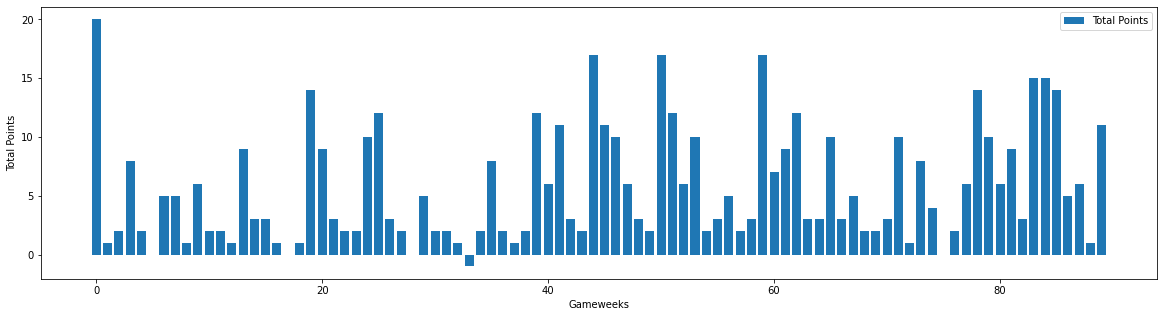

In [18]:
def player_points(full_player_name):
    plt.figure(figsize=(20, 5))
    plt.bar(range(len(df[df['name'] == full_player_name]['total_points'])),
            height=df[df['name'] == full_player_name]['total_points'],
            label='Total Points')
    plt.legend()
    plt.xlabel('Gameweeks')
    plt.ylabel('Total Points')
    plt.show()

#res[res['name'] == ''].plot.bar(x='gameweek', y=['goals_scored', 'assists'])

player_points("Bruno Miguel Borges Fernandes")

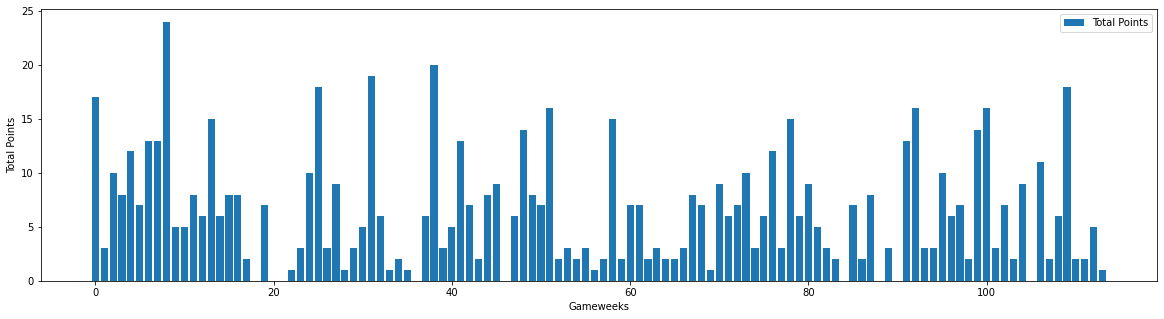

In [19]:
player_points('Mohamed Salah')

## Time-Series Analysis

In [20]:
# Making a new df with binned values
binned_df = df.copy()
binned_df['minutes'] = pd.cut(df['minutes'], bins=10)
binned_df[['name', 'minutes', 'goals_scored', 'assists']].head()

,name,minutes,goals_scored,assists
0,Eric Bailly,"(-0.09, 9.0]",0,0
1,Keinan Davis,"(-0.09, 9.0]",0,0
2,Ayotomiwa Dele-Bashiru,"(-0.09, 9.0]",0,0
3,James Ward-Prowse,"(81.0, 90.0]",0,0
4,Bruno Miguel Borges Fernandes,"(81.0, 90.0]",3,0


Text(0.5, 1.0, 'Average Playing Time per Player')

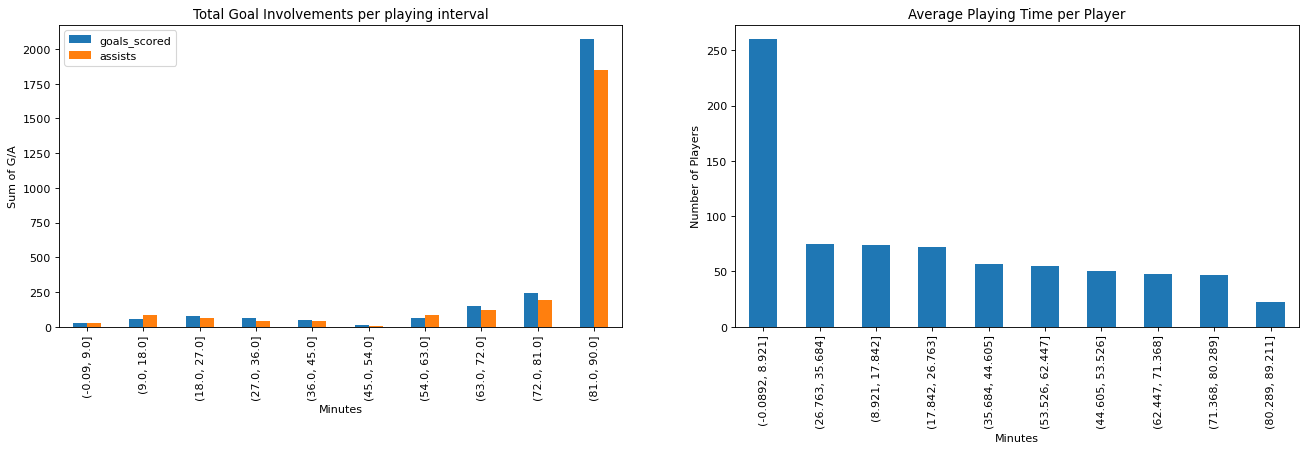

In [21]:
#  Making a sub-plot
fig, axes = plt.subplots(1, 2, figsize=(20,5), dpi= 80)

# Left graph : Total goal involvements for all players by the binned number of minutes
binned_df.groupby(by=['minutes']).sum().plot.bar(y=['goals_scored', 'assists'], ax=axes[0], xlabel='Minutes', ylabel='Sum of G/A')

# Right graph : The average playing time for each player
min_per_player = df.groupby(by=['name']).mean()
min_per_player['minutes'] = pd.cut(min_per_player['minutes'], bins=10)
min_per_player['minutes'].value_counts().plot(kind='bar', ax=axes[1], xlabel='Minutes', ylabel='Number of Players')

# Titles
axes[0].set_title('Total Goal Involvements per playing interval')
axes[1].set_title('Average Playing Time per Player')
# min_per_player['minutes'].value_counts()

No surprise, but players that play for linger time +80 minutes are far more likely to score and assist in games than players with less playing minutes. However, most players have an average playing time of less than 45 minutes. To reduce the total run-time of the point predictions we can reduce the dataset to only include players with an average playing time of 45 minutes or more.

In [22]:
# Creating a list of players with playing time less than 45 minutes
# The players in the list will not be removed at a later time
thres_minutes = 45.0
min_per_player = df.groupby(by=['name']).mean()
keep_players = min_per_player.loc[min_per_player["minutes"] > thres_minutes].index

Looking at the average score of teams based of their FDR:

Text(0.5, 1.0, 'Home team with FDR 5 vs. Opponent Team FDRs')

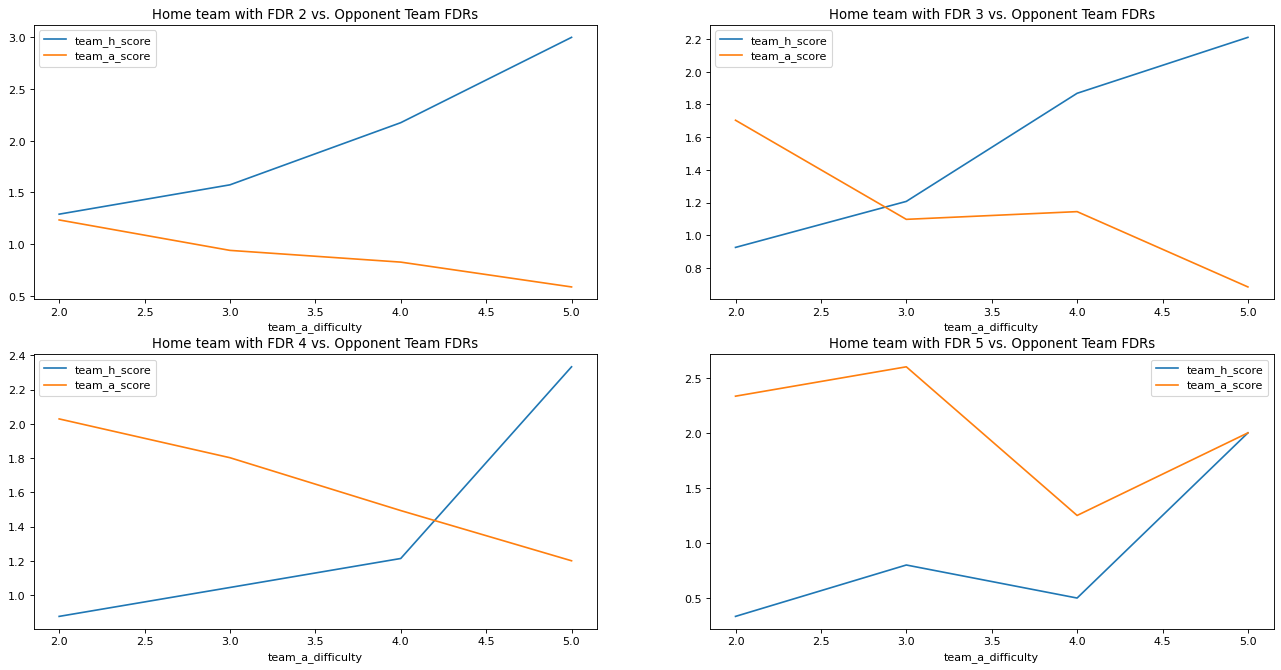

In [23]:
# Looking at the Av
fig, axes = plt.subplots(2, 2, figsize=(20,10), dpi= 80)
fix.groupby(by=['team_h_difficulty', 'team_a_difficulty']).mean().loc[2].plot(y=['team_h_score', 'team_a_score'], ax=axes[0][0])
fix.groupby(by=['team_h_difficulty', 'team_a_difficulty']).mean().loc[3].plot(y=['team_h_score', 'team_a_score'], ax=axes[0][1])
fix.groupby(by=['team_h_difficulty', 'team_a_difficulty']).mean().loc[4].plot(y=['team_h_score', 'team_a_score'], ax=axes[1][0])
fix.groupby(by=['team_h_difficulty', 'team_a_difficulty']).mean().loc[5].plot(y=['team_h_score', 'team_a_score'], ax=axes[1][1])

axes[0][0].set_title("Home team with FDR 2 vs. Opponent Team FDRs")
axes[0][1].set_title("Home team with FDR 3 vs. Opponent Team FDRs")
axes[1][0].set_title("Home team with FDR 4 vs. Opponent Team FDRs")
axes[1][1].set_title("Home team with FDR 5 vs. Opponent Team FDRs")

When the Home Team play against opponents of similar levels (according to the FDR), the scoreline tends to be stable, but when weaker teams play against stronger opponents (Home teams with lower FDR than Away team), the scoreline looks to favour the stronger team. From this we can deduce that it is favourable to have players of strong teams with a favourable fixture in the coming weeks. But does Home teams have an advantage when playing against Away teams?

<AxesSubplot:xlabel='winner'>

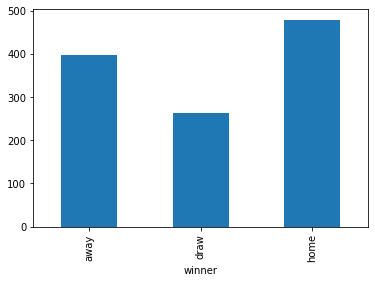

In [24]:
# Adding a feature that shows if the home- or away-team won, or if it was a draw
fix['winner'] = ["home" if fix['team_h_score'].iloc[i] > fix['team_a_score'].iloc[i] else "away" if fix['team_h_score'].iloc[i] < fix['team_a_score'].iloc[i] else "draw" for i in range(fix.shape[0])]

# Grouping by the winner and counting their occurances
hda = fix.groupby(by=['winner']).count()['team_h']

# Plotting the winner
hda.plot(kind='bar')

From this we can see that there is a home field advantage to the distribution of wins vs losses, about 5 %.

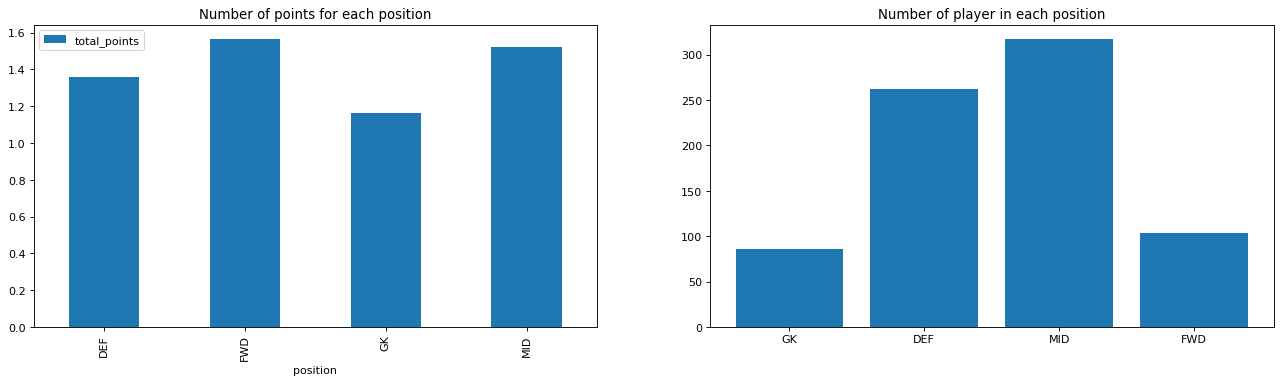

In [25]:
# Replacing Goalkeeper abreviations GKP to GK
df['position'].replace('GKP', 'GK', inplace=True)

# Plotting which positions earn the most fantasy-points
fig, axes = plt.subplots(1, 2, figsize=(20,5), dpi= 80)
df.groupby(by=['position']).mean().plot.bar(y=['total_points'], ax=axes[0])
axes[1].bar(['GK', 'DEF', 'MID', 'FWD'], 
            [len(df.groupby(by=['position', 'name']).count().loc['GK']),
             len(df.groupby(by=['position', 'name']).count().loc['DEF']),
             len(df.groupby(by=['position', 'name']).count().loc['MID']),
             len(df.groupby(by=['position', 'name']).count().loc['FWD'])])

axes[0].set_title('Number of points for each position')
axes[1].set_title('Number of player in each position')
plt.show()

<AxesSubplot:xlabel='position'>

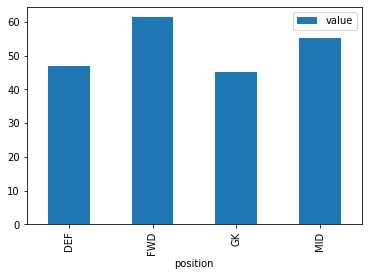

In [26]:
df.groupby(by=['position']).mean().plot.bar(y=['value'])

FPL bases their player values of the demand of the players. Let's look at their point earnings as per their values:

Text(0.5, 1.0, 'Average total points based of player value')

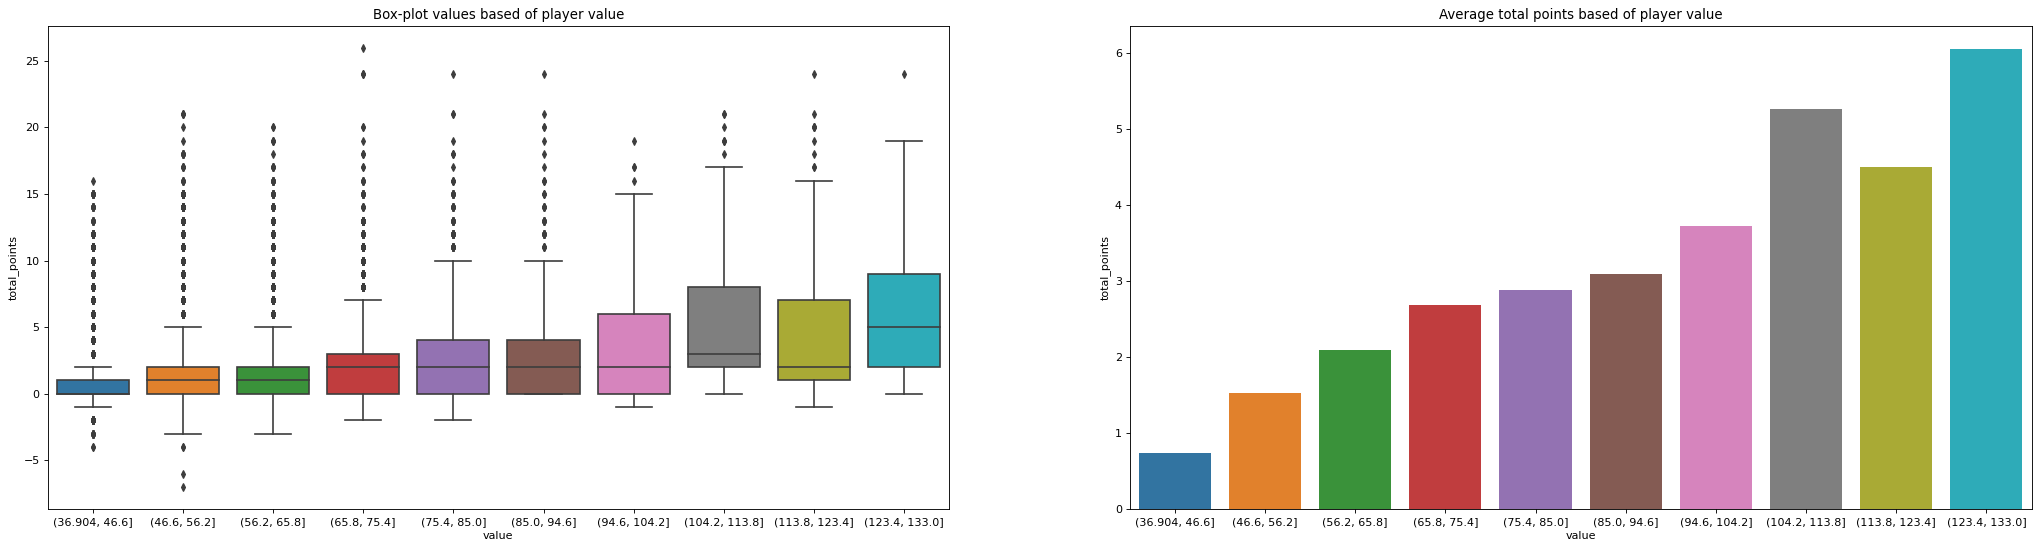

In [27]:
# Binning player values
binned_df['value'] = pd.cut(df['value'], bins=10)

# Grouping the binned values by the means of the numeric features
values = binned_df.groupby(by=['value']).mean()

# Plotting the player values vs. their total point returns
fig, axes = plt.subplots(1, 2, figsize=(32,8), dpi= 80)

# Left graph : Plotting in a box-plot
sns.boxplot(x=binned_df['value'], y=binned_df['total_points'], ax=axes[0])
axes[0].set_title('Box-plot values based of player value')

# Right graph : Plotting in a bar-chart
sns.barplot(x=values.index, y=values['total_points'], ax=axes[1])
axes[1].set_title('Average total points based of player value')

From these graphs it is quite clear that there is a linear relationship between the price of a player and their point returns.

Let's drop some more  features that doesn't explain the total score of players 

In [28]:
# Dropping the only two players with the exact same name (Ben Davies)
# None of them are exeptionally good fantasy players anyways 
df.drop(index=df[df['name'] == 'Ben Davies'].index, axis=0, inplace=True)

# Dropping a few more features that has become irrelevant
df.drop(['round', 'team', 'opponent_team', 'kickoff_time', 'element', 'season', 'team_score', 'opponent_score'], axis=1, inplace=True)

Selecting the players with a history of high returns

In [29]:
# Printing the average, total-fpl-point-return for all players
score = []
for player in pd.unique(df['name']):
    score.append(df[df['name'] == player]['total_points'].sum())

np.mean(score)

113.40447957839262

In [30]:
#score = pd.DataFrame(columns=['name', ['n_total_points']])
#for season in seasons:
#    for player in pd.unique(df[df['season'] == season]['name']):
#        temp = pd.DataFrame(data=[player, season, df[df['name'] == player]['total_points'].count()], columns=['name', 'season', 'points'])
#        score = pd.concat([score, temp])
#score.sort_values(by='n_total_points', axis=1, ascending=False, inplace=True)

### Target Variable Analysis

C:\Users\Joakim Torsvik\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='total_points', ylabel='Density'>

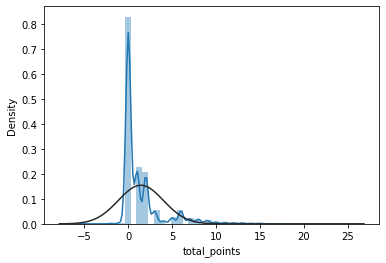

In [31]:
from scipy.stats import norm
# Plotting the distribution of the target variable
sns.distplot(df['total_points'], fit=norm, kde=True)

C:\Users\Joakim Torsvik\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

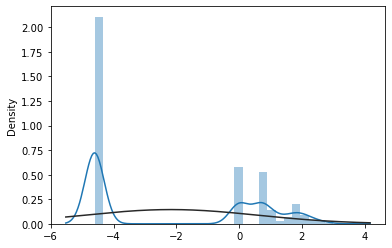

In [32]:
sns.distplot([np.log(x) if x > 0 else np.log(0.01) for x in df['total_points']], fit=norm, kde=True)

<AxesSubplot:xlabel='value', ylabel='total_points'>

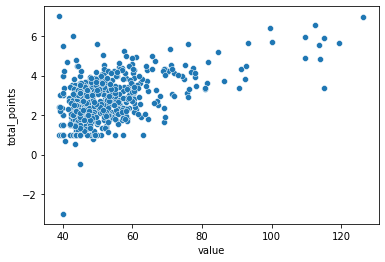

In [33]:
# Plotting each players average point return when they recieve points
sns.scatterplot(data=df[df['total_points'] != 0].groupby(by=['name']).mean(), x='value', y='total_points')

C:\Users\JOAKIM~1\AppData\Local\Temp/ipykernel_6888/566150386.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.scatterplot(x=df[df['position'] == 'GK'][df['total_points'] > 0].groupby(by=['name']).mean()['value'],
C:\Users\JOAKIM~1\AppData\Local\Temp/ipykernel_6888/566150386.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  y=df[df['position'] == 'GK'][df['total_points'] > 0].groupby(by=['name']).sum()['total_points'])


<AxesSubplot:xlabel='value', ylabel='total_points'>

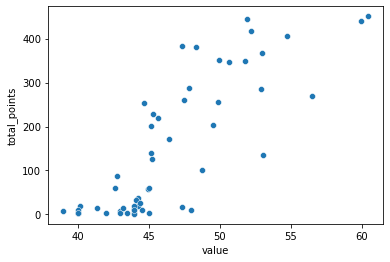

In [34]:
# Plotting the goal-keepers average return when they gain points
sns.scatterplot(x=df[df['position'] == 'GK'][df['total_points'] > 0].groupby(by=['name']).mean()['value'],
                y=df[df['position'] == 'GK'][df['total_points'] > 0].groupby(by=['name']).sum()['total_points'])

C:\Users\JOAKIM~1\AppData\Local\Temp/ipykernel_6888/1057190919.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.scatterplot(x=df[df['position'] == 'DEF'][df['total_points'] > 0].groupby(by=['name']).mean()['value'],
C:\Users\JOAKIM~1\AppData\Local\Temp/ipykernel_6888/1057190919.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  y=df[df['position'] == 'DEF'][df['total_points'] > 0].groupby(by=['name']).sum()['total_points'])


<AxesSubplot:xlabel='value', ylabel='total_points'>

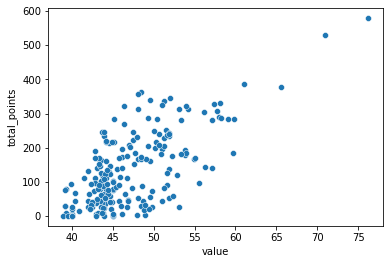

In [35]:
# Plotting the defenders' average return when they gain points
sns.scatterplot(x=df[df['position'] == 'DEF'][df['total_points'] > 0].groupby(by=['name']).mean()['value'],
                y=df[df['position'] == 'DEF'][df['total_points'] > 0].groupby(by=['name']).sum()['total_points'])

C:\Users\JOAKIM~1\AppData\Local\Temp/ipykernel_6888/123388593.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.scatterplot(x=df[df['position'] == 'MID'][df['total_points'] > 0].groupby(by=['name']).mean()['value'],
C:\Users\JOAKIM~1\AppData\Local\Temp/ipykernel_6888/123388593.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  y=df[df['position'] == 'MID'][df['total_points'] > 0].groupby(by=['name']).sum()['total_points'])


<AxesSubplot:xlabel='value', ylabel='total_points'>

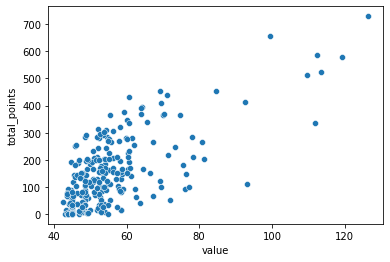

In [36]:
# Plotting the midfielders' average return when they gain points
sns.scatterplot(x=df[df['position'] == 'MID'][df['total_points'] > 0].groupby(by=['name']).mean()['value'],
                y=df[df['position'] == 'MID'][df['total_points'] > 0].groupby(by=['name']).sum()['total_points'])

C:\Users\JOAKIM~1\AppData\Local\Temp/ipykernel_6888/1854248935.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.scatterplot(x=df[df['position'] == 'FWD'][df['total_points'] > 0].groupby(by=['name']).mean()['value'],
C:\Users\JOAKIM~1\AppData\Local\Temp/ipykernel_6888/1854248935.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  y=df[df['position'] == 'FWD'][df['total_points'] > 0].groupby(by=['name']).sum()['total_points'])


<AxesSubplot:xlabel='value', ylabel='total_points'>

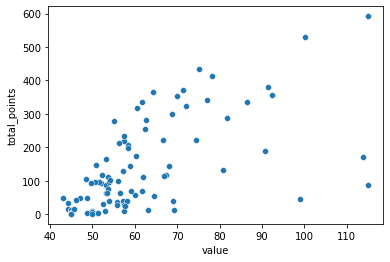

In [37]:
# Plotting the forwards' average return when they gain points
sns.scatterplot(x=df[df['position'] == 'FWD'][df['total_points'] > 0].groupby(by=['name']).mean()['value'],
                y=df[df['position'] == 'FWD'][df['total_points'] > 0].groupby(by=['name']).sum()['total_points'])

### Dropping more players

From the analysis made above, I feel confident in dropping the players that have an average gametime of less than one half of the game. The players to keep in the analysis are stored in the **keep_players** variable.

In [38]:
# Dropping the players that aren't in the keep_players list
for player in pd.unique(df['name']):
    if player not in keep_players:
        df.drop(index=df[df["name"] == player].index, inplace=True)
    elif df[df["name"] == player]['total_points'].count() <= 20:
        df.drop(index=df[df["name"] == player].index, inplace=True)

# Sorting the df by each player, then sorting the individual players' data by their fixture numbers
df.sort_values(['name', 'fixture'], ascending=True, inplace=True)

# Printing the players that are left
print(f"Players left after dropping: {len(pd.unique(df['name']))}")

Players left after dropping: 214


### Correlation Analysis

<AxesSubplot:>

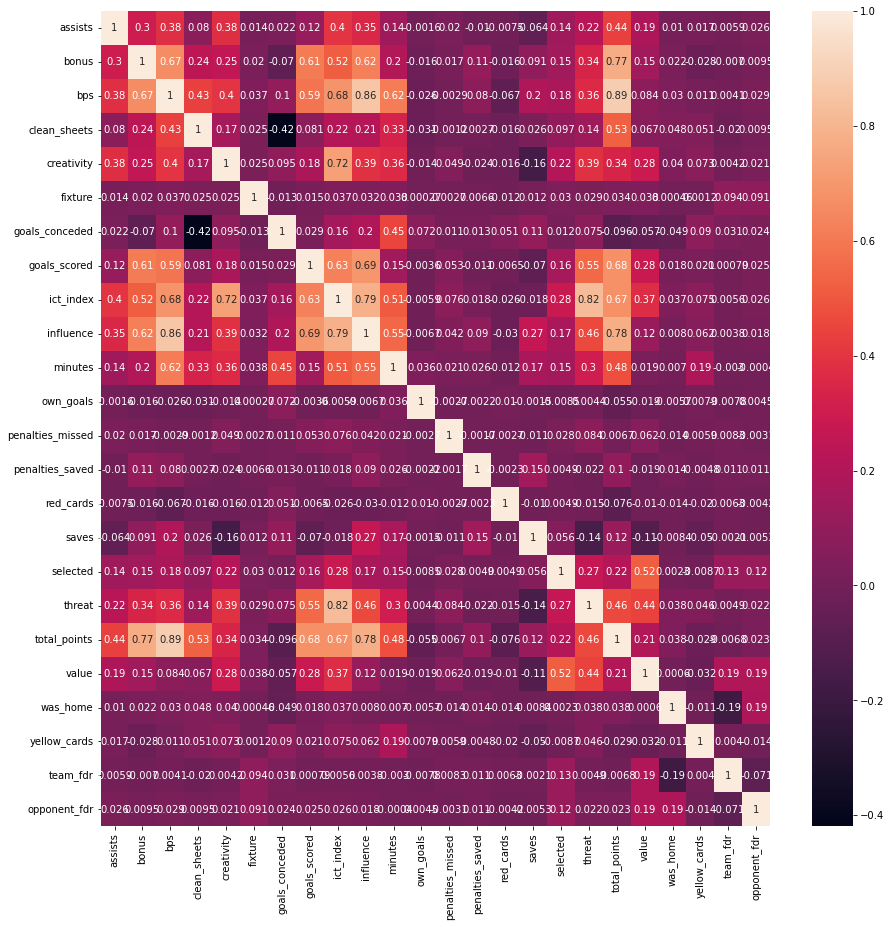

In [39]:
# Plotting the correlation matrix
plt.figure(figsize=(15,15))
sns.heatmap(df.corr(), annot=True)

When comparing the correlation between the dependent variable **total_points** and other features we see that it has a high correlation with **bonus_points** and **bps** which makes sense seeing as bonus points tends to be handed out to players that are very influential in games and manage to gain a lot of points.

### Trend- and seasonality identification

In football there is a lot of talk about a players form and that form is something that rises and falls at unspecific moments in time. However, for autoregressive time-series models (i.e. the ARIMA), cyclical variations such as trends and seasons have to be stationary (i.e., no drastic changes in the distribution over time). In terms of Fantasy Football, this applies to the changes in total points over time.

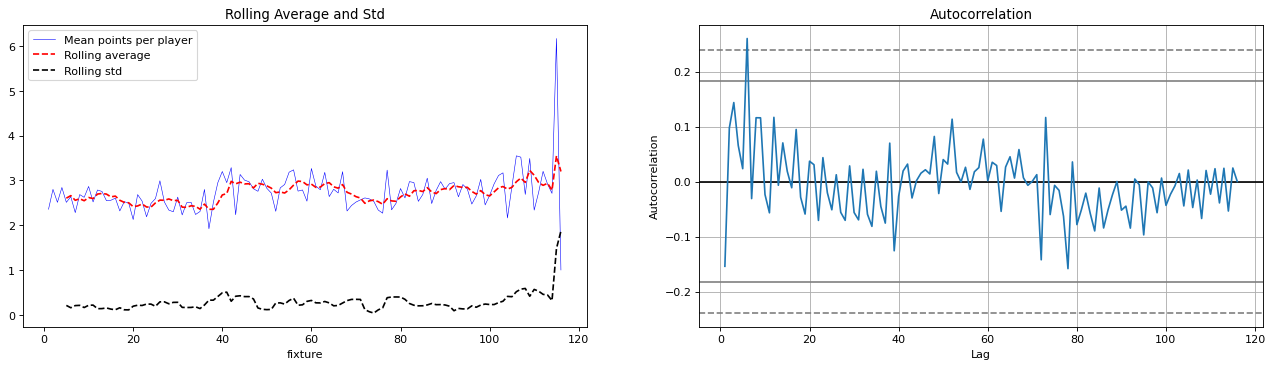

In [40]:
#df['time'] = [str(df['season'].iloc[i]) + ", " + str(df['fixture'].iloc[i]) for i in range(df.shape[0])]

# Grouping the fixture-nr for all players
mean_points = df.groupby(['fixture']).mean()

# Threshold for the rolling average and std
thres = 5

# Plotting the stationarity of all players combined
fig, axes = plt.subplots(1, 2, figsize=(20,5), dpi=80)

# Left graph : Rolling average and std
mean_points['total_points'].plot(label='Mean points per player', color='blue', lw=0.5, ax=axes[0])
mean_points['total_points'].rolling(thres).mean().plot(label='Rolling average', style='--', color='red', ax=axes[0])
mean_points['total_points'].rolling(thres).std().plot(label='Rolling std', style='--', color='black', ax=axes[0])
axes[0].legend()

# Right graph : Autocorrelation
pd.plotting.autocorrelation_plot(mean_points['total_points'], ax=axes[1])

# Graph titles
axes[0].set_title("Rolling Average and Std")
axes[1].set_title("Autocorrelation")
plt.show()

For the collective mean of all players, we see that there is some non-stationarity, but this most likely could be the cause of a few players playing more than 38 gameweeks per season (due to transfers, as explained above). The Autocorrelation plot on the right also shows that apart from a few instances, the autocorrelation is very low (between 0.2 and -0.2). Thus it could be determined that the distribution of the mean total points of all players is stationary. However, what about individually? Is there a lot of stationarity in their total point distributions? Let's look at the autocorrelational- and distributional plots of 5 desireable players in different positions:

Mohamed Salah


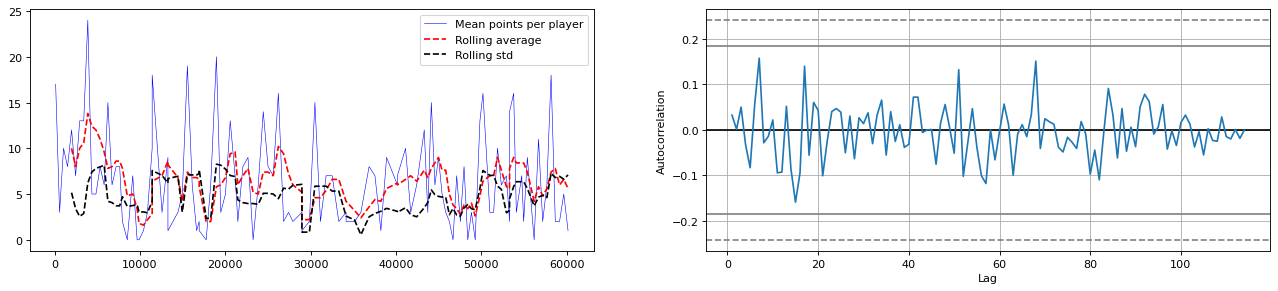

Kevin De Bruyne


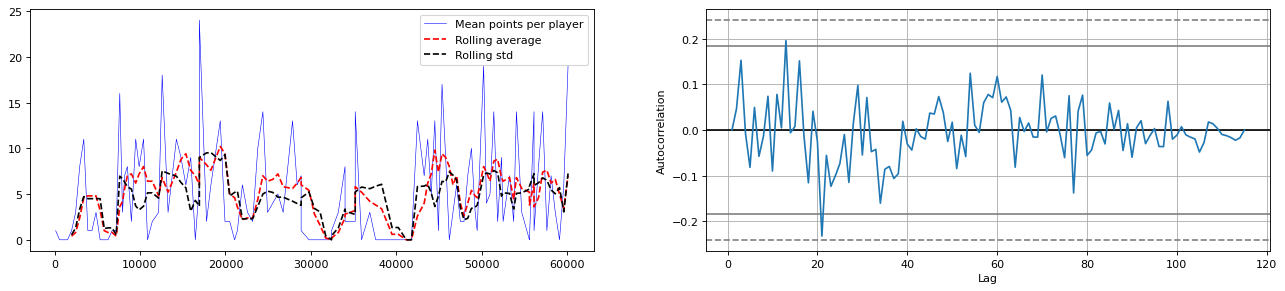

Virgil van Dijk


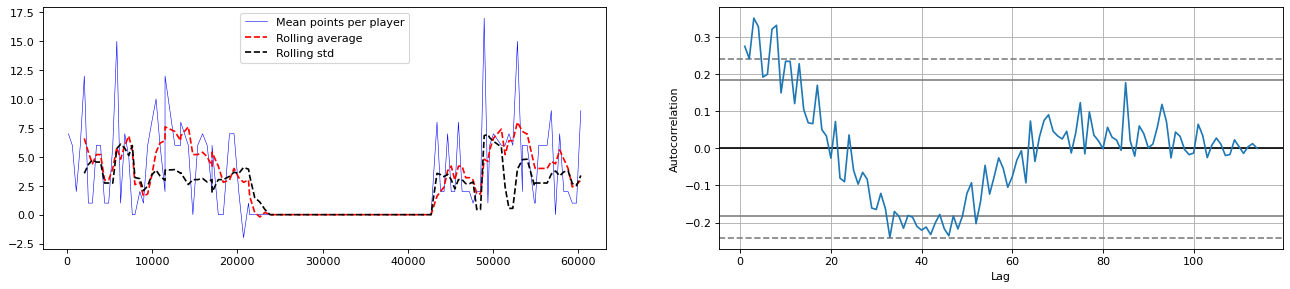

Harry Kane


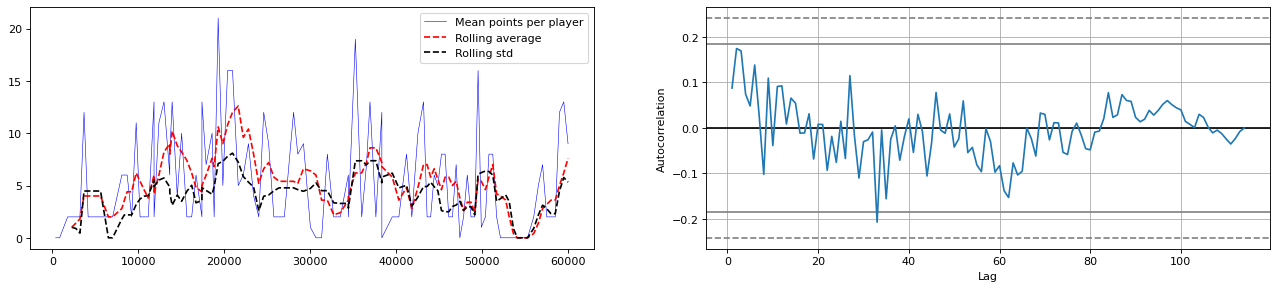

Ederson Santana de Moraes


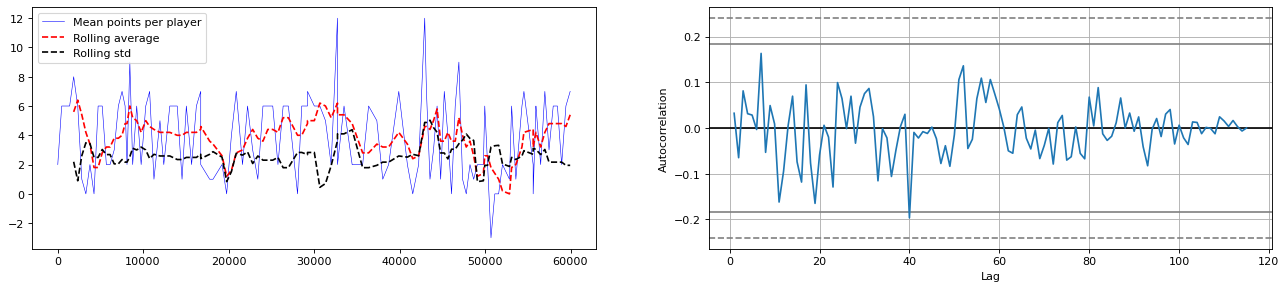

In [41]:
players = ['Mohamed Salah', 'Kevin De Bruyne', 'Virgil van Dijk', 'Harry Kane', 'Ederson Santana de Moraes']

# Plotting the same as above, but for the individual players in the "players" variable 
for player in players:
    thres = 5
    print(player)
    # Rolling avg and std
    fig, axes = plt.subplots(1, 2, figsize=(20,4), dpi=80)
    df[df['name'] == player]['total_points'].plot(label='Mean points per player', color='blue', lw=0.5, ax=axes[0])
    df[df['name'] == player]['total_points'].rolling(thres).mean().plot(label='Rolling average', style='--', color='red', ax=axes[0])
    df[df['name'] == player]['total_points'].rolling(thres).std().plot(label='Rolling std', style='--', color='black', ax=axes[0])
    axes[0].legend()

    # Autocorrelation
    pd.plotting.autocorrelation_plot(df[df['name'] == player]['total_points'], ax=axes[1])
    plt.show()

Reviewing the plots from these players, it is clear to see that there isn't much stationarity to be found with individual players (apart from the periods when they are injured and not playing). To further determine stationarity of these players, the Augmented Dickey-Fuller test can be used.

### Augmented Dickey-Fuller test:

The ADF-test is a hypothesis test where $H_0$ states that the data is non-stationary, and $H_A$ states that the data is stationary. The critical value is set by the user, but also displayed critical values for 1%, 5% and 10%.
 
$ H_0: \mu >= 0.05$ - Data is non-stationary\
$H_A: \mu < 0.05$ - Data is stationary

In [42]:
# Getting the ADF of all players combined
adf = adfuller(mean_points['total_points'])
print(f"Test stat: {round(adf[0], 5)} \ p-value: {round(adf[1], 5)} \ n_lags: {adf[2]}")
print(f"Critical Values: {adf[4]}")

Test stat: -1.36341 \ p-value: 0.59969 \ n_lags: 5
Critical Values: {'1%': -3.4912451337340342, '5%': -2.8881954545454547, '10%': -2.5809876033057852}


In [43]:
# Getting the ADF of the players in the "players" variable
for player in players:
    adf = adfuller(df[df['name'] == player]['total_points'])
    print(player)
    print(f"Test stat: {round(adf[0], 5)} \ p-value: {round(adf[1], 5)} \ n_lags: {adf[2]}")
    print(f"Critical Values: {adf[4]}")
    print() # Space between each player outputs

Mohamed Salah
Test stat: -10.33523 \ p-value: 0.0 \ n_lags: 0
Critical Values: {'1%': -3.489589552580676, '5%': -2.887477210140433, '10%': -2.580604145195395}

Kevin De Bruyne
Test stat: -10.28967 \ p-value: 0.0 \ n_lags: 0
Critical Values: {'1%': -3.489057523907491, '5%': -2.887246327182993, '10%': -2.5804808802708528}

Virgil van Dijk
Test stat: -3.4522 \ p-value: 0.0093 \ n_lags: 2
Critical Values: {'1%': -3.490683082754047, '5%': -2.8879516565798817, '10%': -2.5808574442009578}

Harry Kane
Test stat: -4.30369 \ p-value: 0.00044 \ n_lags: 2
Critical Values: {'1%': -3.490683082754047, '5%': -2.8879516565798817, '10%': -2.5808574442009578}

Ederson Santana de Moraes
Test stat: -10.20774 \ p-value: 0.0 \ n_lags: 0
Critical Values: {'1%': -3.489057523907491, '5%': -2.887246327182993, '10%': -2.5804808802708528}



## Predicting Player Performances with ML

To solve this econometric problem statement I will implement several Machine Learning models that are used in econometry and computer science to find the correct answer:
1. ARMA / ARIMA (Autoregressive (Integrated) Moving Average)
2. Support Vector Machine
3. Gradient Boosting with XGBoost
4. Recurrent Neural Network with Long Short-Term Memory (RNN-LSTM)

In [44]:
print(df.columns)
df.head()

Index(['name', 'position', 'assists', 'bonus', 'bps', 'clean_sheets',
       'creativity', 'fixture', 'goals_conceded', 'goals_scored', 'ict_index',
       'influence', 'minutes', 'own_goals', 'penalties_missed',
       'penalties_saved', 'red_cards', 'saves', 'selected', 'threat',
       'total_points', 'value', 'was_home', 'yellow_cards', 'team_fdr',
       'opponent_fdr'],
      dtype='object')


,name,position,assists,bonus,bps,clean_sheets,creativity,fixture,goals_conceded,goals_scored,...,red_cards,saves,selected,threat,total_points,value,was_home,yellow_cards,team_fdr,opponent_fdr
442,Aaron Cresswell,DEF,0,0,30.0,0,17.5,1.0,2,1,...,0,0,1213434,18.0,7,55,0,0,3,2
904,Aaron Cresswell,DEF,0,0,12.0,0,4.2,2.0,1,0,...,0,0,1345295,6.0,2,55,1,0,2,3
1372,Aaron Cresswell,DEF,1,1,26.0,0,17.2,3.0,2,0,...,0,0,1402594,2.0,5,55,1,0,2,3
1843,Aaron Cresswell,DEF,0,2,27.0,1,24.6,4.0,0,0,...,0,0,1324980,9.0,8,55,0,0,3,2
2318,Aaron Cresswell,DEF,0,0,15.0,0,27.3,5.0,2,0,...,0,0,1265797,0.0,1,55,1,0,3,3


In [45]:
# Player to be tested upon
player = 'Mohamed Salah'

### ARIMA

 - AR (AutoRegressive) = Takes a parameterized lagged value (p) and regresses it with the later value, similar to that of a linear correlation. For non-stationary data, the AR should be set to 1 or 0.
 - I (Integrated) = Takes the lagged value form the AR and integrates it with a parameterized value (d).
 - MA (Moving Average) = Takes a parameterized window of values (q) and finds the average value of this window.

To calculate the differences between the observed- and the predicted values, the **Mean Squared Error (MSE)** is utilized. The MSE is a measure of distance from the observed value ($y$) and the predicted value (${\hat{y}}$), where larger distances have a larger significance.  
$ MSE = \frac{\sum{(y_i-\hat{y_i})^2}}{n}$

Mohamed Salah
Lowest MSE: 35.06667370335935
Parameters: [p:1.0, d:0.0, q:1.0]


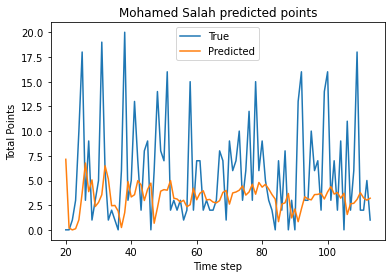

In [46]:
# Removing the warnings from the ARIMA-model
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.simplefilter('ignore', UserWarning)
print(player)

# Log transformation of the players total points 
total_points = df[df['name'] == player]['total_points'].to_numpy()
# Converging 0 values to the log of a value close to zero.
log_total = [float(np.log(x)) if x > 0 else float(np.log(0.01)) for x in total_points] 

# Tuning the p,d,q parameters
params = pd.DataFrame()
for p in range(1, 3): # Tuning p param
    for d in range(0, 4): # Tuning d param
        for q in range(1, 4): # Tuning q param
            y_pred = []
            ys = []
            # Walk Forward Validation of ARIMA
            for i in range(20, len(log_total)): # Training on 20+i gameweeks
                # Train-test-split
                history, y = log_total[:i], log_total[i]

                # Training and testing
                # Due to non-stationarity of player data, we set enforce_stationarity to False
                model = ARIMA(history, order=(p,d,q), enforce_stationarity=False)
                model_fit = model.fit()
                y_hat = model_fit.forecast()
                y_pred.append(np.exp(y_hat))
                ys.append(np.exp(y))

            
            # Appending the p, d, q values and their MSE
            params = params.append({'p':p, # Lag value
                                    'd':d, # Differentiation
                                    'q':q, # Moving Average window size
                                    'MSE':mean_squared_error(ys, y_pred)}, ignore_index=True)


# Locating the parameters with the lowest MSE
mse_idx = params['MSE'].idxmin()
print(f"Lowest MSE: {params.iloc[mse_idx]['MSE']}")
print(f"Parameters: [p:{params.iloc[mse_idx]['p']}, d:{params.iloc[mse_idx]['d']}, q:{params.iloc[mse_idx]['q']}]")

p = params.iloc[mse_idx]['p'] # best lag param
d = params.iloc[mse_idx]['d'] # best differentiation param
q = params.iloc[mse_idx]['q'] # best MA-window-size param

ys = []
ts = []
y_pred = []
# preds = []

# Walk Forward Validation of ARIMA with tuned params
for i in range(20, len(log_total)):
    # train-test-split
    history, y = log_total[:i], log_total[i]
    
    # Training and testing
    model = ARIMA(history, order=(p,d,q), enforce_stationarity=False)
    model_fit = model.fit()
    y_hat = model_fit.forecast()
    # preds.append([i, y_hat[0], y])
    ts.append(i)
    y_pred.append(np.exp(y_hat))
    ys.append(np.exp(y))

# Plotting the results of the ARIMA with tuned params
plt.plot(ts, ys, label='True')
plt.plot(ts, y_pred, label='Predicted')
plt.legend()
plt.title(f'{player} predicted points')
plt.xlabel('Time step')
plt.ylabel('Total Points')
plt.show()

Due to the movements of the variables, the ARIMA finds it very difficult to accurately predict next weeks total points based of just the univariate approach. In this case, ARMA becomes a better 

In [47]:
# Getting the WF validation of ARIMA-predictions of all remaining players
arima_res = {}
# For-loop of all players
for _player in pd.unique(df['name']):

    # Removing warnings (again)
    warnings.simplefilter('ignore', ConvergenceWarning)
    warnings.simplefilter('ignore', UserWarning)
    y_pred = []
    ys = []

    # Log Transformation
    total_points = df[df['name'] == _player]['total_points'].to_numpy()
    log_total = [np.log(x) if x > 0 else np.log(0.01) for x in total_points]

    # Walk Forward Validation of ARIMA
    for i in range(20, len(log_total)):
        history, y = log_total[:i], log_total[i]
        model = ARIMA(history, order=(1,0,1), enforce_stationarity=False)
        model_fit = model.fit()
        y_hat = model_fit.forecast()
        y_pred.append(np.exp(y_hat))
        ys.append(np.exp(y))

    arima_res[player] = [ys, y_pred]
    # rmse = np.sqrt(mean_squared_error(ys, y_pred))
    # print(f"Player : {player} | RMSE : {rmse}")

sum_mse = 0 # Sum of all players' MSE
count = 0 # Number of players
for v in arima_res.values():
    count += 1
    sum_mse += mean_squared_error(v[0], v[1])

# Getting the average of the MSE for all players predictions with the ARIMA
average_mse = sum_mse/count
print(f"Average MSE per player: {average_mse}")

Average MSE per player: 11.270650418271222


Due to the non-stationarity in the data, it is very difficult for the ARIMA to make an accurate prediction on which players will do well in the upcoming game weeks. That being said, the model is *fairly* capable of producing generalized version of how a player has performed in recent gameweeks. By looking at Kevin De Bruyne, a player one would generally like to have in their team, he is predicted to score +5 goals.

### XGBoost

With time-series modelling, models like ARIMA, VAR and linear regressions tends to be the most generally applied methods. However, with implementation of Machine Learning, decision trees have become more and more popular with Random Forests and XGBoost being the front-runners.

A major difference from the previous ARIMA-model to that of XGBoost and SVMs is that these models will use multi-variate data, meaning multiple features will be used in contrast to ARIMA where only Total Points were used (Univariate). In order to treat this problem with supervised learning, we need to use a *lagging-method* where the input values represent the predictor data and the output values represent the predicted data.

In [48]:
def series_to_supervised(data, n_lags=1, n_out=1, dropnan=True, ws=6):

    """Converting the Time Series dataframe into a supervised learning dataframe"""

    # Converting in-game statistics into average form in previous gameweeks
    # Previous gameweeks is set by the window size (ws)
    new_df = pd.DataFrame()
    for col in data.columns:
        if col not in ['name', 'position', 'team_fdr', 'opponent_fdr', 'total_points']:
            new_df[col] = [data[col].iloc[0 : i].mean() if i < ws else data[col].iloc[(i-ws) : i].mean() for i in range(1, data.shape[0] + 1)]
        else:
            new_df[col] = data[col]

    # Input Sequence
    for lag in range(n_lags, 0, -1):
        for col in data.columns:
            if col not in ['name', 'position']:
                name = col + " (t-" + str(n_lags) + ")"
                new_df[name] = data[col].shift(lag)

    # Forecasting Sequence
    for step in range(0, n_out):
        for col in data.columns:
            if col not in ['name', 'position']:
                if step == 0:
                    name = col + " (t)"
                else:
                    name = col + " (t+" + str(step) + ")"
                new_df[name] = data[col].shift(-step)
    
    # Removing NaN from the new dataframe
    new_df.dropna(inplace=True)

    return new_df

 Player: Mohamed Salah ---  MSE: 27.17784711302566


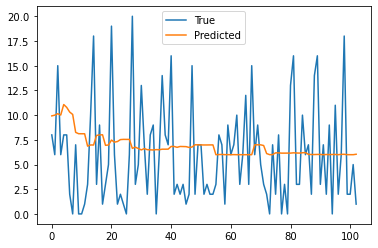

In [49]:
# Testing XGB with player df
new_df = copy.deepcopy(df[df['name'] == player])

# Converting the time series df to supervised learning df
new_df = series_to_supervised(new_df, 3, 1)

# Splitting the df with x and y data
x_data = new_df.reset_index(drop=True).drop(['name', 'position', 'total_points (t)'], axis=1)
# Converging 0 values to the log of a value close to zero.
y_data = pd.DataFrame([np.log(x) if x != 0 else np.log(0.01) for x in new_df['total_points (t)']])

# Testing the XGBoost with Walk Forward Validation
y_true=[]
y_predicted=[]
# Walk Forward with XGBoost
for i in range(10, len(total_points)-1):
    
    # Getting the training data and the testing data
    x_train, y_train = x_data[:i], y_data[:i]
    x_pred, y_pred = x_data.iloc[i], y_data.iloc[i]
    x_pred = pd.DataFrame(x_pred).transpose()

    # Normalizing the x data
    sc = StandardScaler()
    x_train = sc.fit_transform(x_train)
    x_pred = sc.fit_transform(x_pred)
    
    # Training and testing
    regressor = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000)
    regressor.fit(x_train, y_train)
    y_hat = regressor.predict(x_pred)

    # print(f"{y_pred} | {y_hat[0]}")
    y_true.append(np.exp(y_pred))
    y_predicted.append(np.exp(y_hat[0]))

# Maing a df of the true values and results
d = {"True" : y_true,
     "Predicted" : y_predicted}
df_temp = pd.DataFrame.from_dict(d)

# Plotting the XGBoost results
mse = mean_squared_error(y_true, y_predicted)
print(f" Player: {player} ---  MSE: {mse}")
plt.plot(df_temp.index, df_temp['True'], label='True')
plt.plot(df_temp.index, df_temp['Predicted'], label='Predicted')
plt.legend()

In [50]:
# Running XGBoost on all players
xgb_res = {}
for _player in pd.unique(df['name']):
    new_df = copy.deepcopy(df[df['name'] == _player])
    new_df = series_to_supervised(new_df, 3, 1)
    x_data = new_df.reset_index(drop=True).drop(['name', 'position', 'total_points (t)'], axis=1)
    # Converging 0 values to the log of a value close to zero.
    y_data = pd.DataFrame([np.log(x) if x > 0 else np.log(0.01) for x in new_df['total_points (t)']])

    y_true = []
    y_predicted = []
    # Walk Forward with XGBoost
    for i in range(10, len(y_data)-1):
        # Getting the training data and the testing data
        x_train, y_train = x_data[:i], y_data[:i]
        x_pred, y_pred = x_data.iloc[i], y_data.iloc[i]
        x_pred = pd.DataFrame(x_pred).transpose()

        # Normalizing the x data
        sc = StandardScaler()
        x_train = sc.fit_transform(x_train)
        x_pred = sc.fit_transform(x_pred)

        # Training and testing
        regressor = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000)
        regressor.fit(x_train, y_train)
        y_hat = regressor.predict(x_pred)

        # print(f"{y_pred} | {y_hat[0]}")
        y_true.append(np.exp(y_pred).round(2))
        y_predicted.append(np.exp(y_hat[0]).round(2))
    xgb_res[player] = [y_true, y_predicted]

In [51]:
sum_mse = 0 # Sum of MSE of all players
count = 0 # Count of players
for v in xgb_res.values():
    count += 1
    sum_mse += mean_squared_error(v[0], v[1])

average_mse = sum_mse/count # Average MSE of all players
print(f"Average MSE per player: {average_mse}")

Average MSE per player: 8.891360800619687


In [52]:
sum_rmse = 0 # Sum of RMSE of all players
count = 0 # Count of players
for v in xgb_res.values():
    count += 1
    sum_rmse += mean_squared_error(v[0], v[1], squared=False)

average_rmse = sum_rmse/count # Average rMSE of all players
print(f"Average RMSE per player: {average_rmse}")

Average RMSE per player: 2.981838493382847


### SVM

In [53]:
new_df = copy.deepcopy(df[df['name'] == player])
new_df = series_to_supervised(new_df, 3, 1)
x_data = new_df.reset_index(drop=True).drop(['name', 'position'], axis=1)
# Converging 0 values to the log of a value close to zero.
y_data = pd.DataFrame([np.log(x) if x > 0 else np.log(0.01) for x in new_df['total_points (t)']])
# Tuning hyper-param epsilon
epsilon = [0.1, 1, 5, 10, 100]


svm_results = []
for e in epsilon:
    y_true=[]
    y_predicted=[]
    # Walk Forward with SVM
    for i in range(10, len(y_data)-1):
        # train-test-split
        x_train, y_train = x_data[:i], y_data[:i]
        x_pred, y_pred = x_data.iloc[i], y_data.iloc[i]
        x_pred = pd.DataFrame(x_pred).transpose()

        # Normalizing
        sc = StandardScaler()
        x_train = sc.fit_transform(x_train)
        x_pred = sc.fit_transform(x_pred)

        # Training and testing
        regressor = SVR(kernel='rbf', epsilon=e)
        regressor.fit(x_train, y_train)
        y_hat = regressor.predict(x_pred)
        y_true.append(np.exp(y_pred))
        y_predicted.append(np.exp(y_hat[0]))
    svm_results.append([e, mean_squared_error(y_true, y_predicted)])

pd.DataFrame(svm_results, columns=['epsilon', 'MSE'])

,epsilon,MSE
0,0.1,28.046897
1,1.0,35.641344
2,5.0,51.835079
3,10.0,51.835079
4,100.0,51.835079


 Player: Mohamed Salah ---  MSE: 28.046897475156307


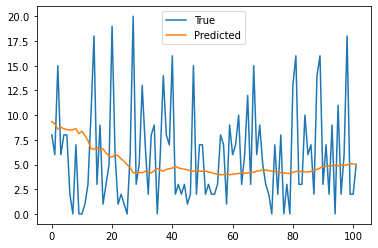

In [54]:
new_df = copy.deepcopy(df[df['name'] == player])
new_df = series_to_supervised(new_df, 3, 1)
x_data = new_df.reset_index(drop=True).drop(['name', 'position'], axis=1)
# Converging 0 values to the log of a value close to zero.
y_data = pd.DataFrame([np.log(x) if x > 0 else np.log(0.01) for x in new_df['total_points (t)']])

y_true=[]
y_predicted=[]
# Walk Forward with SVM
for i in range(10, len(y_data)-1):
    # train-test-split
    x_train, y_train = x_data[:i], y_data[:i]
    x_pred, y_pred = x_data.iloc[i], y_data.iloc[i]
    x_pred = pd.DataFrame(x_pred).transpose()

    # Normalizing
    sc = StandardScaler()
    x_train = sc.fit_transform(x_train)
    x_pred = sc.fit_transform(x_pred)

    # Training and predicting 
    regressor = SVR(kernel='rbf', epsilon=0.1)
    regressor.fit(x_train, y_train)
    y_hat = regressor.predict(x_pred)

    # print(f"{y_pred} | {y_hat[0]}")
    y_true.append(np.exp(y_pred))
    y_predicted.append(np.exp(y_hat[0]))


d={"True" : y_true,
   "Predicted" : y_predicted}


df_temp = pd.DataFrame.from_dict(d)
# display(df_temp)
mse = mean_squared_error(y_true, y_predicted)
print(f" Player: {player} ---  MSE: {mse}")
plt.plot(df_temp.index, df_temp['True'], label='True')
plt.plot(df_temp.index, df_temp['Predicted'], label='Predicted')
plt.legend()

In [55]:
svm_res = {}
for _player in pd.unique(df['name']):   
    new_df = copy.deepcopy(df[df['name'] == _player])
    new_df = series_to_supervised(new_df, 3, 1)
    x_data = new_df.reset_index(drop=True).drop(['name', 'position', 'total_points (t)'], axis=1)
    # Converging 0 values to the log of a value close to zero.
    y_data = pd.DataFrame([np.log(x) if x > 0 else np.log(0.01) for x in new_df['total_points (t)']])

    y_true = []
    y_predicted = []
    # Walk Forward with SVM
    for i in range(10, len(y_data)-1):
        # train-test-split
        x_train, y_train = x_data[:i], y_data[:i]
        x_pred, y_pred = x_data.iloc[i], y_data.iloc[i]
        x_pred = pd.DataFrame(x_pred).transpose()

        # Normalizing
        sc = StandardScaler()
        x_train = sc.fit_transform(x_train)
        x_pred = sc.fit_transform(x_pred)

        # Training and testing
        regressor = SVR()
        regressor.fit(x_train, y_train)
        y_hat = regressor.predict(x_pred)

        # print(f"{y_pred} | {y_hat[0]}")
        y_true.append(y_pred)
        y_predicted.append(y_hat[0])
    svm_res[player] = [y_true, y_predicted]

In [56]:
sum_mse = 0 # Sum of MSE of all players
count = 0 # Count of players
for v in svm_res.values():
    count += 1
    sum_mse += mean_squared_error(v[0], v[1])

average_mse = sum_mse/count # Average MSE of all players
print(f"Average MSE per player: {average_mse}")

Average MSE per player: 8.538328824502358


In [57]:
sum_rmse = 0 # Sum of RMSE of all players
count = 0 # Count of players
for v in svm_res.values():
    count += 1
    sum_rmse += mean_squared_error(v[0], v[1], squared=False)

average_rmse = sum_rmse/count # Average RMSE of all players
print(f"Average RMSE per player: {average_rmse}")

Average RMSE per player: 2.9220418930094683


Both the SVM and the XGBoost underfits in their predictions. This is probably because the dataset isn't explanatory enough to give the models the necessarry information to be able to predict anything other than a "score" seemingly close to the mean of the player. This could help to classify which player could be considered to be selected and which is not, but to predict their future points is too complex of a task.

### Recurrent Neural Network with Long Short-Term Memory (RNN-LSTM)

In [58]:
# 1 = Visualizing training progress
# 0 = Don't
verbose = 0

# Creating a dense RNN-LSTM model with Dropout
def rnn_lstm(shape):
    input_layer = Input(shape=shape) # Input layer of the model
    x = Sequential()(input_layer) # Setting the model to be sequential, i.e. move from t=1 to t=2 etc.
    # print(x.shape)
    x = LSTM(64, return_sequences=True, activation="tanh")(x) # Setting the model to RNN-LSTM with 64 initial hidden layers
    # print(x.shape)
    x = Dropout(0.3)(x) # Adding a Dropout-layer
    # print(x.shape)
    x = LSTM(64)(x) # Adding another hidden-layer 
    # print(x.shape)
    output_layer = Dense(1)(x) # 1-Dimensional output-layer y
    model = keras.models.Model(inputs=input_layer, outputs=output_layer) # Fitting the layers into the model
    model.compile(loss='mse', optimizer=keras.optimizers.Adam(), # Optimizer Adam
                  metrics=[keras.metrics.MeanSquaredError(), # Optimizer metric MSE
                           keras.metrics.RootMeanSquaredError()]) # Second optimizer RMSE
    return model


new_df = copy.deepcopy(df[df['name'] == player])
new_df = series_to_supervised(new_df, 3, 1)
x_data = new_df.reset_index(drop=True).drop(['name', 'position'], axis=1)
# Converging 0 values to the log of a value close to zero.
y_data = pd.DataFrame([np.log(x) if x > 0 else np.log(0.01) for x in new_df['total_points (t)']])

input_shape = (x_data.shape[1], 1)
rnn_lstm(input_shape).summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 72, 1)]           0         
                                                                 
 sequential (Sequential)     multiple                  0         
                                                                 
 lstm (LSTM)                 (None, 72, 64)            16896     
                                                                 
 dropout (Dropout)           (None, 72, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 49,985
Trainable params: 49,985
Non-trainable p

In [59]:
# Setting an early stopping parameter when the model has stopped improving
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

y_true=[]
y_predicted=[]
count = 0
epochs = 50

# Walk Forward with RNN-LSTM
for i in range(10, len(y_data)-1):
    # Train-test-split
    x_train, y_train = x_data[:i], y_data[:i]
    x_pred, y_pred = x_data.iloc[i], y_data.iloc[i]
    x_pred = pd.DataFrame(x_pred).transpose()

    # Normalizing
    sc = StandardScaler()
    x_train = sc.fit_transform(x_train)
    x_pred = sc.fit_transform(x_pred)

    # Training and testing
    input_shape = (x_data.shape[1], 1)
    model = rnn_lstm(input_shape)
    model.fit(x_train, y_train, epochs=epochs, callbacks=[callback], verbose=verbose)
    y_hat = model.predict(x_pred)

    # print(f"{y_pred} | {y_hat[0]}")
    y_true.append(np.exp(y_pred))
    y_predicted.append(np.exp(y_hat[0]))

d={"True" : y_true,
   "Predicted" : y_predicted}
df_temp = pd.DataFrame.from_dict(d)

 Player: Mohamed Salah ---  MSE: 37.44930616071627


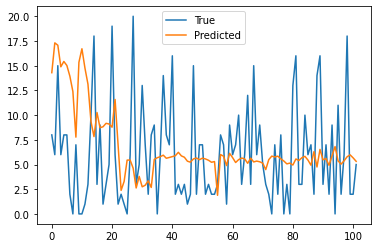

In [60]:
# Plotting the RNN results
mse = mean_squared_error(y_true, y_predicted)
print(f" Player: {player} ---  MSE: {mse}")
plt.plot(df_temp.index, df_temp['True'], label='True')
plt.plot(df_temp.index, df_temp['Predicted'], label='Predicted')
plt.legend()
plt.show()